This script performs multi-objective optimization of a stiffened plate using NSGA-II.
The two objectives to minimize are:
1. The mass of the plate.
2. The maximum von Mises stress.

The optimization is performed using the pymoo framework, and results are visualized
in a Pareto front plot.

In [2]:
import numpy as np
import joblib
import os
import time

import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from tensorflow.keras.models import load_model

In [3]:
# Set global font to Times New Roman and control default font size
plt.rcParams["font.family"] = "Times New Roman"

# Specifying text sizes used in the next sections
labelsize = 18
titlesize = 20
legendsize = 16

In [4]:
# GPR paths
model_path = "models/final_gpr_model.pkl"
scaler_path = "models/final_scaler.pkl"
# Load the exquisitely trained GPR model and scaler
gpr = joblib.load(model_path)
gpr_scaler = joblib.load(scaler_path)

# GPR Pareto Front

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     13 |             - |             -
     2 |      200 |     18 |  0.0041843754 |         ideal
     3 |      300 |     25 |  0.0386527283 |         ideal
     4 |      400 |     29 |  0.0186698234 |         ideal
     5 |      500 |     38 |  0.0042492826 |         ideal
     6 |      600 |     54 |  0.0031287955 |         nadir
     7 |      700 |     70 |  0.0040221094 |         nadir
     8 |      800 |     72 |  0.0025620313 |             f
     9 |      900 |     79 |  0.0049665214 |         ideal
    10 |     1000 |     88 |  0.0026191881 |             f
    11 |     1100 |     92 |  0.0107378288 |         nadir
    12 |     1200 |     93 |  0.0390314002 |         nadir
    13 |     1300 |    100 |  0.0233698614 |         nadir
    14 |     1400 |    100 |  0.0015097007 |             f
    15 |     1500 |    100 |  0.0053433372 |         nadir
    16 |     1600 |    100 |  0.0012948600 |            

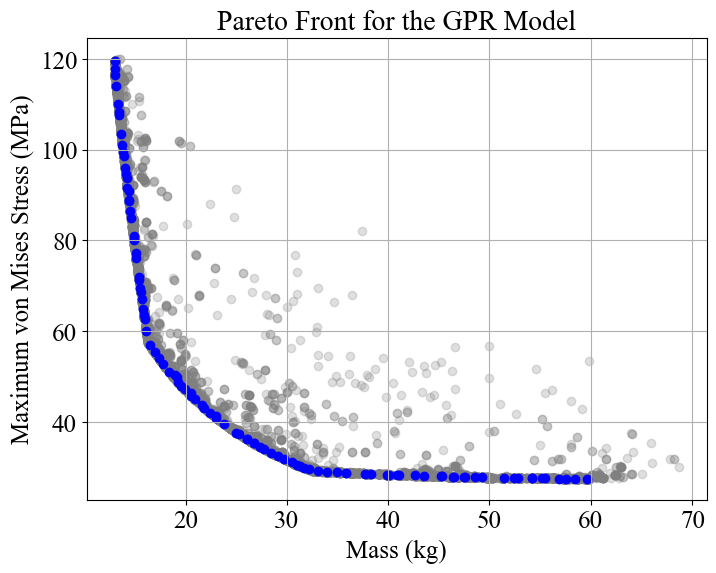

GPR Pareto runtime was: 1.8942 seconds


In [5]:
gpr_pareto_start = time.time()
# Constants
rho = 2700  # Density of aluminum alloy (kg/m^3)

# Variable bounds for design parameters
# W1: Plate half-width (m), W2: Maintenance port half-width (m), R: Maintenance port fillet radius (m), t: Plate thickness (m)
upper_bounds = np.array([0.6, 0.2, 0.06, 0.02])  # Maximum values
lower_bounds = np.array([0.4, 0.1, 0.04, 0.01])  # Minimum values

# Define the optimization problem class
class PlateOptimization(Problem):
    def __init__(self):
        super().__init__(n_var=4,  # Number of design variables
                         n_obj=2,  # Number of objectives (mass and stress)
                         n_constr=0,  # No constraints in this problem
                         xl=lower_bounds,  # Lower bounds for variables
                         xu=upper_bounds)  # Upper bounds for variables

    def _evaluate(self, X, out, *args, **kwargs):
        # Extract design variables from the input matrix
        W1, W2, R, t = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

        # Compute the mass of the plate
        mass_values = rho * t * (4 * W1**2 - 4 * W2**2 + (4 - np.pi) * R**2)

        X_scaled = gpr_scaler.transform(X)
        stress_values = gpr.predict(gpr_scaler.transform(X))
        
        # Store the two objectives (mass and stress) for optimization
        out["F"] = np.column_stack([mass_values, stress_values])

# Define the optimization algorithm (NSGA-II)
algorithm = NSGA2(
    pop_size=100,  # Population size
    sampling=LHS(),  # Use Latin Hypercube Sampling for better diversity in initial population
    crossover=SBX(prob=0.9, eta=15),  # Simulated Binary Crossover (SBX)
    mutation=PM(prob=0.2, eta=20),  # Polynomial Mutation (PM)
    eliminate_duplicates=True  # Remove duplicate solutions
)

# Instantiate the optimization problem
problem = PlateOptimization()

# Run the optimization process
res = minimize(problem,
               algorithm,
               ("n_gen", 100),  # Number of generations for evolution
               seed=1,
               verbose=True,
               save_history=True)  # Save full optimization history for analysis

# Extract the final Pareto-optimal solutions
pareto_front = res.F  # Objective values of Pareto-optimal solutions
masses_pareto, stresses_pareto = pareto_front[:, 0], pareto_front[:, 1]

# Extract all sub-optimal solutions from optimization history
all_solutions = np.vstack([gen.pop.get("F") for gen in res.history])
masses_all, stresses_all = all_solutions[:, 0], all_solutions[:, 1]

# Plot the Pareto Front and Sub-Optimal Solutions
plt.figure(figsize=(8, 6))
plt.title("Pareto Front for the GPR Model", fontsize = titlesize)
plt.scatter(masses_all, stresses_all, c="gray", alpha=0.25, label="Sub-Optimal Solutions")
plt.scatter(masses_pareto, stresses_pareto, c="blue", label="Pareto Front (Optimal Solutions)")
plt.xlabel("Mass (kg)", fontsize=labelsize)
plt.ylabel("Maximum von Mises Stress (MPa)", fontsize=labelsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.grid(True)
plt.savefig("figures/Pareto_Front_GPR.png", dpi=500)  # Save the figure
plt.show()

gpr_pareto_end = time.time()
gpr_pareto_runtime_s = gpr_pareto_end - gpr_pareto_start
print(f"GPR Pareto runtime was: {gpr_pareto_runtime_s:.4f} seconds")

In [6]:
# Average design: [W1, W2, R, t]
average_design = np.array([[0.5, 0.15, 0.05, 0.015]])

# Extract variables
W1 = average_design[0, 0]
W2 = average_design[0, 1]
R = average_design[0, 2]
t = average_design[0, 3]

# Compute average mass
avg_mass = rho * t * (4 * W1**2 - 4 * W2**2 + (4 - np.pi) * R**2)

# Predict stress using GPR model
avg_stress = gpr.predict(gpr_scaler.transform(average_design))[0]

# Print average design results
print(f"Average Design -> Mass: {avg_mass:.2f} kg, σ_max: {avg_stress:.2f} MPa\n")

# Compare Pareto-optimal designs
print("Pareto Designs Better than Average in Both Objectives:\n")
better_count = 0

for i in range(len(masses_pareto)):
    mass = masses_pareto[i]
    stress = stresses_pareto[i]

    if mass < avg_mass and stress < avg_stress:
        design = res.X[i]
        mass_diff = 100 * (mass - avg_mass) / avg_mass
        stress_diff = 100 * (stress - avg_stress) / avg_stress

        print(f"Design {i + 1}:")
        print(f"W1 = {design[0]:.4f} m, W2 = {design[1]:.4f} m, R = {design[2]:.4f} m, t = {design[3]:.4f} m")
        print(f"Mass = {mass:.2f} kg ({mass_diff:+.2f}%)")
        print(f"sigma_max = {stress:.2f} MPa ({stress_diff:+.2f}%)\n")

        better_count += 1

# If none are better
if better_count == 0:
    print("No Pareto-optimal designs are better in both stress and mass.")

Average Design -> Mass: 36.94 kg, σ_max: 50.32 MPa

Pareto Designs Better than Average in Both Objectives:

Design 4:
W1 = 0.4001 m, W2 = 0.1003 m, R = 0.0599 m, t = 0.0146 m
Mass = 23.84 kg (-35.46%)
sigma_max = 39.54 MPa (-21.42%)

Design 16:
W1 = 0.4000 m, W2 = 0.1001 m, R = 0.0600 m, t = 0.0154 m
Mass = 25.03 kg (-32.24%)
sigma_max = 37.64 MPa (-25.19%)

Design 21:
W1 = 0.4135 m, W2 = 0.1000 m, R = 0.0600 m, t = 0.0200 m
Mass = 34.94 kg (-5.43%)
sigma_max = 28.88 MPa (-42.61%)

Design 22:
W1 = 0.4000 m, W2 = 0.1006 m, R = 0.0599 m, t = 0.0129 m
Mass = 20.95 kg (-43.28%)
sigma_max = 44.97 MPa (-10.63%)

Design 25:
W1 = 0.4000 m, W2 = 0.1010 m, R = 0.0600 m, t = 0.0188 m
Mass = 30.53 kg (-17.36%)
sigma_max = 31.09 MPa (-38.21%)

Design 29:
W1 = 0.4187 m, W2 = 0.1000 m, R = 0.0600 m, t = 0.0200 m
Mass = 35.87 kg (-2.91%)
sigma_max = 28.77 MPa (-42.82%)

Design 34:
W1 = 0.4001 m, W2 = 0.1000 m, R = 0.0600 m, t = 0.0155 m
Mass = 25.24 kg (-31.68%)
sigma_max = 37.34 MPa (-25.80%)

Design

# Neural Network Pareto Front

In [7]:
# NN Paths
nn_model = load_model("models/nn_model.keras")
input_scaler = joblib.load("models/nn_input_scaler.pkl")
output_scaler = joblib.load("models/nn_output_scaler.pkl")

2025-05-05 18:43:25.892508: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-05 18:43:25.892575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-05 18:43:25.892590: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-05 18:43:25.892639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 18:43:25.892667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-05-05 18:43:28.029338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     12 |             - |             -
     2 |      200 |     17 |  0.0131404862 |         ideal
     3 |      300 |     19 |  0.0161074649 |         ideal
     4 |      400 |     27 |  0.0127628044 |         ideal
     5 |      500 |     27 |  0.0032112788 |         ideal
     6 |      600 |     38 |  0.0183235532 |         ideal
     7 |      700 |     46 |  0.0063902842 |             f
     8 |      800 |     64 |  0.0048309371 |             f
     9 |      900 |     75 |  0.0045347874 |         ideal
    10 |     1000 |     97 |  0.0118296575 |         nadir
    11 |     1100 |    100 |  0.0037163221 |             f
    12 |     1200 |    100 |  0.0047131648 |         ideal
    13 |     1300 |    100 |  0.0013754870 |             f
    14 |     1400 |    100 |  0.0066502965 |         nadir
    15 |     1500 |    100 |  0.0291684473 |         nadir
    16 |     1600 |    100 |  0.0008618053 |            

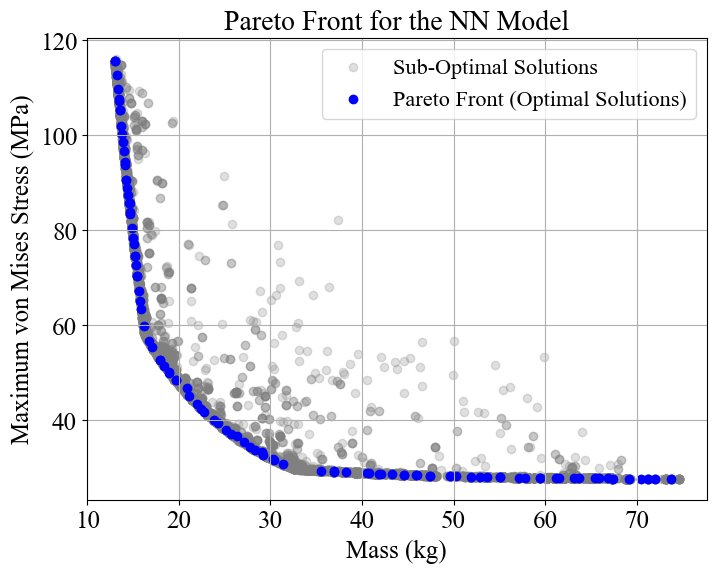

NN Pareto runtime was: 4.3514 seconds


In [8]:
nn_pareto_start = time.time()
# Constants
rho = 2700  # Density of aluminum alloy (kg/m^3)

# Variable bounds for design parameters
# W1: Plate half-width (m), W2: Maintenance port half-width (m), R: Maintenance port fillet radius (m), t: Plate thickness (m)
upper_bounds = np.array([0.6, 0.2, 0.06, 0.02])  # Maximum values
lower_bounds = np.array([0.4, 0.1, 0.04, 0.01])  # Minimum values

# Define the optimization problem class
class PlateOptimization(Problem):
    def __init__(self):
        super().__init__(n_var=4,  # Number of design variables
                         n_obj=2,  # Number of objectives (mass and stress)
                         n_constr=0,  # No constraints in this problem
                         xl=lower_bounds,  # Lower bounds for variables
                         xu=upper_bounds)  # Upper bounds for variables

    def _evaluate(self, X, out, *args, **kwargs):
        # Extract design variables from the input matrix
        W1, W2, R, t = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

        # Compute the mass of the plate
        mass_values = rho * t * (4 * W1**2 - 4 * W2**2 + (4 - np.pi) * R**2)

        X_scaled = input_scaler.transform(X)
        y_pred_scaled = nn_model.predict(X_scaled, verbose=0)
        stress_values = output_scaler.inverse_transform(y_pred_scaled).flatten()
        
        # Store the two objectives (mass and stress) for optimization
        out["F"] = np.column_stack([mass_values, stress_values])

# Define the optimization algorithm (NSGA-II)
algorithm = NSGA2(
    pop_size=100,  # Population size
    sampling=LHS(),  # Use Latin Hypercube Sampling for better diversity in initial population
    crossover=SBX(prob=0.9, eta=15),  # Simulated Binary Crossover (SBX)
    mutation=PM(prob=0.2, eta=20),  # Polynomial Mutation (PM)
    eliminate_duplicates=True  # Remove duplicate solutions
)

# Instantiate the optimization problem
problem = PlateOptimization()

# Run the optimization process
res = minimize(problem,
               algorithm,
               ("n_gen", 100),  # Number of generations for evolution
               seed=1,
               verbose=True,
               save_history=True)  # Save full optimization history for analysis

# Extract the final Pareto-optimal solutions
pareto_front = res.F  # Objective values of Pareto-optimal solutions
masses_pareto, stresses_pareto = pareto_front[:, 0], pareto_front[:, 1]

# Extract all sub-optimal solutions from optimization history
all_solutions = np.vstack([gen.pop.get("F") for gen in res.history])
masses_all, stresses_all = all_solutions[:, 0], all_solutions[:, 1]

# Plot the Pareto Front and Sub-Optimal Solutions
plt.figure(figsize=(8, 6))
plt.title("Pareto Front for the NN Model", fontsize = titlesize)
plt.scatter(masses_all, stresses_all, c="gray", alpha=0.25, label="Sub-Optimal Solutions")
plt.scatter(masses_pareto, stresses_pareto, c="blue", label="Pareto Front (Optimal Solutions)")
plt.xlabel("Mass (kg)", fontsize = labelsize)
plt.ylabel("Maximum von Mises Stress (MPa)", fontsize = labelsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.legend(fontsize = legendsize)
plt.grid(True)
plt.savefig("figures/Pareto_Front_NN.png", dpi=500)  # Save the figure
plt.show()

nn_pareto_end = time.time()
nn_pareto_runtime_s = nn_pareto_end - nn_pareto_start
print(f"NN Pareto runtime was: {nn_pareto_runtime_s:.4f} seconds")